In [1]:
from datasets import load_dataset, Dataset
import datasets

import re
import string
import emoji
import pymorphy3
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.optim import lr_scheduler


from gensim.models import Word2Vec

from nltk.corpus import stopwords
import os
import torch.nn.functional as F
import pandas as pd
import random
from tqdm import tqdm
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EvalPrediction,
    pipeline,
)

from collections import Counter, OrderedDict

In [2]:
seed = 42

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Используется:", device)


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(seed=seed)

Используется: mps


In [3]:
train_dataset = load_dataset("csv", data_files="train.csv", sep=",", split="train")
test_dataset = load_dataset("csv", data_files="test.csv", sep=",", split="train")

In [4]:
train_dataset["text"][:5]

['15 января\nДетская развлекательная программа\n15-00 бесплатно\n❗️\n@\ncafeotdyh\nКафе "Отдых"\n📍\nЗапись обязательно +73472228532',
 '13 и 14 августа\nВыходные в Меге\nhttps://t.me/megaufa_official\nМегапарк',
 'Йокнапатофа\nПостановка Театр им. Маяковского\nБилеты от 500 до 2000 р.',
 'Впервые в Уфе танцевальная терапия в группе с практикующим психологом\nТема встречи: «Отношения. Доверие. Контакт»\nПриходите, если:\n🔸\nвы хотите наладить или поисследовать свои отношения с\n-\xa0 телом\n- собой\n- близким человеком\n- работой\n- деньгами\n🔸\nне можете разрешить или забыть какую-то\xa0 ситуацию, связанную с отношениями\n🔸\nне умеете доверять или делегировать\n🔸\nтяжело вступаете в контакт\nЗадать вопрос психологу курса\nи записаться можно здесь:\n@LeontevaKsenia\nДата\n: 26 января\nВремя\n: 19.00-21.00\nАдрес\n: Коммунистическая, 45/3, Б/ц "Деловой двор"\nСтоимость: 1500\nЧто нужно для занятия:\nудобная одежда, носки, вода, желание танцевать.',
 '🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья

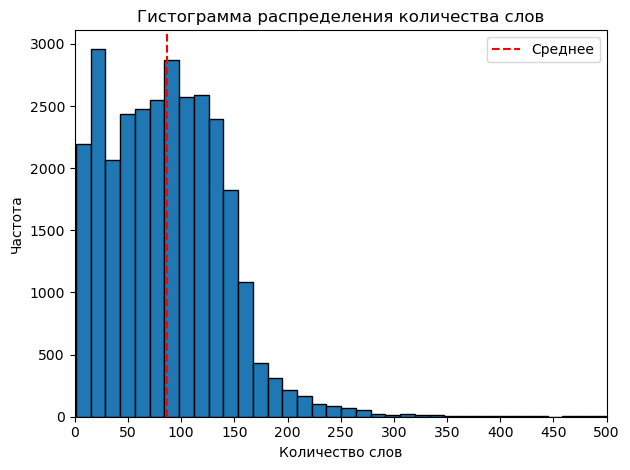

среднее количество слов в тексте: 86.61


In [5]:
word_counts = []

for i, item in enumerate(train_dataset):
    text = item["text"]
    words = text.split()
    word_count = len(words)
    word_counts.append(word_count)

plt.hist(word_counts, bins=50, edgecolor="black")

plt.xlabel("Количество слов")
plt.xticks(np.arange(0, 1000, step=50))
plt.xlim(0, 500)
plt.ylabel("Частота")
plt.title(f"Гистограмма распределения количества слов")
plt.axvline(np.mean(word_counts), color="red", linestyle="--", label="Среднее")
plt.legend()
plt.tight_layout()
plt.show()

print(f"среднее количество слов в тексте: {np.mean(word_counts):.2f}")

In [6]:
morph = pymorphy3.MorphAnalyzer(lang="ru")
russian_stopwords = set(stopwords.words("russian"))
english_stopwords = set(stopwords.words("english"))
all_stopwords = russian_stopwords.union(english_stopwords)  # Объединяем для простоты


def clean_text(dict_data, MIN_WORD_LENGTH=3, keep_numbers=False, normalize_yo=True):
    text = dict_data.get("text")

    if (
        not isinstance(text, str) or not text.strip()
    ):  # Проверяем также на строки только из пробелов
        return {**dict_data, "text": ""}

    # 1. Перевод в нижний регистр
    text = text.lower()

    # 1.5. Опциональная нормализация "ё" -> "е"
    if normalize_yo:
        text = text.replace("ё", "е")

    # 2. Удаление символов новой строки, заменяя их на пробел
    text = text.replace("\n", " ")

    # 3. Удаление URL-адресов (простая регулярка)
    text = re.sub(r"http[s]?://\S+|www\.\S+", "", text)

    # 4. Удаление эмодзи
    text = emoji.replace_emoji(text, replace="")

    # 5. Удаление пунктуации. Сначала заменяем пунктуацию на пробелы,
    punctuation_to_remove = string.punctuation

    translator = str.maketrans(punctuation_to_remove, " " * len(punctuation_to_remove))
    text = text.translate(translator)

    # 6. Удаление любых небуквенных символов (оставляем только буквы и пробелы, опционально цифры)
    if keep_numbers:
        text = re.sub(r"[^а-яa-z0-9\s]", "", text)
    else:
        text = re.sub(r"[^а-яa-z\s]", "", text)

    # 7. Токенизация (разбиение на слова по одному или нескольким пробелам)
    tokens = text.split()

    # 8. Лемматизация
    lemmatized_tokens = []
    for word in tokens:
        if word:  # Дополнительная проверка, хотя split() обычно не дает пустых строк
            p = morph.parse(word)[0]
            lemmatized_tokens.append(p.normal_form)

    # 9. Удаление стоп-слов и коротких слов (применяем к лемматизированным токенам)
    cleaned_tokens = [
        word
        for word in lemmatized_tokens
        if word not in all_stopwords and len(word) >= MIN_WORD_LENGTH
    ]

    # 10. Объединение слов обратно в строку
    cleaned_text = " ".join(cleaned_tokens)

    # Обработка labels
    labels_data = dict_data.get("labels")
    parsed_labels = []  # Инициализируем как пустой список по умолчанию
    if labels_data is not None:
        if isinstance(labels_data, str) and labels_data.strip():
            parsed_labels = [int(x) for x in labels_data.split()]
        elif isinstance(labels_data, (list, tuple)):
            parsed_labels = [int(x) for x in labels_data if str(x).strip().isdigit()]

    return {**dict_data, "text": cleaned_text, "labels": parsed_labels}

In [7]:
cleared_dataset_train = train_dataset.map(clean_text, num_proc=16)
cleared_dataset_test = test_dataset.map(clean_text, num_proc=16)

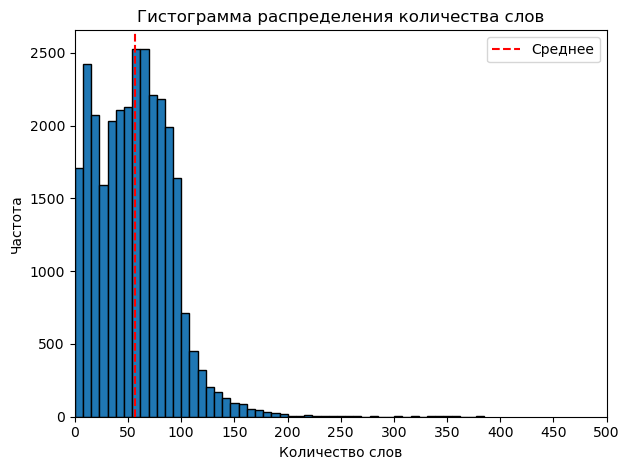

среднее количество слов в тексте: 56.64


In [8]:
word_counts = []

for i, item in enumerate(cleared_dataset_train):
    text = item["text"]
    words = text.split()
    word_count = len(words)
    word_counts.append(word_count)

plt.hist(word_counts, bins=50, edgecolor="black")

plt.xlabel("Количество слов")
plt.xticks(np.arange(0, 1000, step=50))
plt.xlim(0, 500)
plt.ylabel("Частота")
plt.title(f"Гистограмма распределения количества слов")
plt.axvline(np.mean(word_counts), color="red", linestyle="--", label="Среднее")
plt.legend()
plt.tight_layout()
plt.show()

print(f"среднее количество слов в тексте: {np.mean(word_counts):.2f}")

In [9]:
cleared_dataset_train = cleared_dataset_train.train_test_split(test_size=0.2, seed=42)

In [10]:
train_texts = cleared_dataset_train["train"]["text"]
val_texts = cleared_dataset_train["test"]["text"]
test_texts = cleared_dataset_test["text"]

# TF-IDF (ТОП МОДЕЛЬ, ВНИЗУ ОНА ДАНА, НО КОД ДО ЭТОГО МОМЕНТА НАДО ВЫПОЛНИТЬ)

In [ ]:
vectorizer_tfidf = TfidfVectorizer(
    max_features=20000, min_df=2, ngram_range=(1, 2), max_df=0.95
)

vectorizer_tfidf.fit(train_texts)

In [ ]:
X_train_tfidf = vectorizer_tfidf.transform(train_texts)
X_val_tfidf = vectorizer_tfidf.transform(val_texts)

In [ ]:
y_train = cleared_dataset_train["train"]["labels"]
y_val = cleared_dataset_train["test"]["labels"]

y_train_tensor = torch.tensor(y_train, dtype=torch.float)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

X_train_tensor_tfidf = torch.from_numpy(X_train_tfidf.todense()).float()
X_val_tensor_tfidf = torch.from_numpy(X_val_tfidf.todense()).float()

train_dataset_tfidf = TensorDataset(X_train_tensor_tfidf, y_train_tensor)
val_dataset_tfidf = TensorDataset(X_val_tensor_tfidf, y_val_tensor)

batch_size = 256

train_loader_tfidf = DataLoader(
    train_dataset_tfidf, batch_size=batch_size, shuffle=True
)
val_loader_tfidf = DataLoader(val_dataset_tfidf, batch_size=batch_size, shuffle=False)

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_labels):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 5120)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(5120, 1024)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(1024, num_labels)

    def forward(self, x):
        hidden = self.fc1(x)
        hidden = self.relu(hidden)
        hidden = self.fc2(hidden)
        hidden = self.relu(hidden)
        logits = self.fc3(hidden)
        return logits

In [ ]:
def train_epoch(model, train_dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataloader.dataset)
    return epoch_loss


def evaluate_model(model, val_dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).int()

            all_labels.append(labels.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())

    epoch_loss = running_loss / len(val_dataloader.dataset)

    all_labels = np.concatenate(all_labels, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    f1_macro = f1_score(all_labels, all_predictions, average="macro", zero_division=0)

    return epoch_loss, f1_macro


def _plot_metrics(epochs_list, train_losses, val_losses, val_f1_scores, epoch_best):
    plt.figure(figsize=(12, 5))

    actual_epochs = len(train_losses)
    epochs_plot = epochs_list[:actual_epochs]
    train_losses_plot = train_losses[:actual_epochs]
    val_losses_plot = val_losses[:actual_epochs]
    val_f1_scores_plot = val_f1_scores[:actual_epochs]

    plt.subplot(1, 2, 1)
    plt.plot(epochs_plot, train_losses_plot, label="Тренировочные потери")
    plt.plot(epochs_plot, val_losses_plot, label="Валидационные потери")
    plt.axvline(x=epoch_best, color="red", linestyle="--", label="Лучшая эпоха")
    plt.xlabel("Эпоха")
    plt.ylabel("Потери (Loss)")
    plt.title("Потери на тренировочном и валидационном наборах")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(
        epochs_plot, val_f1_scores_plot, label="Валидационный F1-Macro", color="orange"
    )
    plt.axvline(x=epoch_best, color="red", linestyle="--", label="Лучшая эпоха")
    plt.xlabel("Эпоха")
    plt.ylabel("F1-Macro")
    plt.title("F1-Macro на валидационном наборе")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def train(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    initial_optimizer,
    num_epochs,
    second_optimizer=None,
    metric_to_monitor="f1_macro",
    metric_patience=5,
    early_stopping_patience=None,
    initial_scheduler=None,
    device=device,
    best_model_save_path="models/model.pth",
):
    model.to(device)

    current_optimizer = initial_optimizer
    current_scheduler = initial_scheduler

    train_losses = []
    val_losses = []
    val_f1_scores = []
    epochs_list_full = list(range(1, num_epochs + 1))

    if metric_to_monitor == "f1_macro":
        best_metric = float("-inf")
        metric_comparison_op = np.greater
    elif metric_to_monitor == "val_loss":
        best_metric = float("inf")
        metric_comparison_op = np.less
    else:
        raise ValueError("metric_to_monitor must be 'f1_macro' or 'val_loss'")

    epochs_since_improvement = 0
    optimizer_switched = False
    epoch_best = -1

    for epoch in epochs_list_full:
        print(f"Эпоха {epoch}/{num_epochs}")
        print(
            f"Текущий оптимизатор: {type(current_optimizer).__name__}, LR: {current_optimizer.param_groups[0]['lr']:.6f}"
        )

        train_loss = train_epoch(
            model, train_dataloader, criterion, current_optimizer, device
        )
        train_losses.append(train_loss)
        print(f"Тренировочные потери (Loss): {train_loss:.4f}")

        val_loss, val_f1 = evaluate_model(model, val_dataloader, criterion, device)
        val_losses.append(val_loss)
        val_f1_scores.append(val_f1)
        print(f"Валидационные потери (Loss): {val_loss:.4f}, F1 Macro: {val_f1:.4f}")

        current_metric_value = val_f1 if metric_to_monitor == "f1_macro" else val_loss

        if metric_comparison_op(current_metric_value, best_metric):
            best_metric = current_metric_value
            epochs_since_improvement = 0
            if not os.path.exists(os.path.dirname(best_model_save_path)):
                os.makedirs(os.path.dirname(best_model_save_path), exist_ok=True)
            torch.save(model.state_dict(), best_model_save_path)
            epoch_best = epoch
            print(
                f"  Метрика ({metric_to_monitor}) улучшилась. Сохранена лучшая модель."
            )
        else:
            epochs_since_improvement += 1
            print(
                f"  Метрика ({metric_to_monitor}) не улучшилась. Эпох без улучшения: {epochs_since_improvement}"
            )

        if (
            not optimizer_switched
            and second_optimizer is not None
            and epochs_since_improvement >= metric_patience
        ):
            print(
                f"\n  Метрика '{metric_to_monitor}' не улучшалась в течение {metric_patience} эпох."
            )
            print("  Переключение оптимизатора...")

            current_optimizer = second_optimizer
            optimizer_switched = True
            epochs_since_improvement = 0
            current_scheduler = None

            print(
                f"  Теперь используется {type(current_optimizer).__name__} с LR={current_optimizer.param_groups[0]['lr']:.6f}"
            )

        if current_scheduler is not None:
            current_scheduler.step()
            print(
                f"  Шедулер сделал шаг. Текущий LR: {current_optimizer.param_groups[0]['lr']:.6f}"
            )

        if (
            early_stopping_patience is not None
            and epochs_since_improvement >= early_stopping_patience
        ):
            print(
                f"\nРанняя остановка! Метрика '{metric_to_monitor}' не улучшалась в течение {early_stopping_patience} эпох."
            )
            break

        print("-" * 20)

    if os.path.exists(best_model_save_path):
        model.load_state_dict(torch.load(best_model_save_path))
        print("Веса лучшей модели успешно загружены.")

    final_epoch_for_plot = epoch_best if epoch_best != -1 else len(train_losses)
    _plot_metrics(
        epochs_list_full, train_losses, val_losses, val_f1_scores, final_epoch_for_plot
    )

    return model

In [ ]:
model_tfidf = MLPClassifier(
    input_dim=X_val_tfidf.shape[1],
    num_labels=y_train_tensor.shape[1],
).to(device)

criterion = nn.BCEWithLogitsLoss()
initial_optimizer = optim.AdamW(model_tfidf.parameters(), lr=1e-4)
second_optimizer = optim.AdamW(model_tfidf.parameters(), lr=1e-5)
initial_scheduler = optim.lr_scheduler.CosineAnnealingLR(initial_optimizer, T_max=20)

training_results = train(
    model_tfidf,
    train_loader_tfidf,
    val_loader_tfidf,
    criterion,
    initial_optimizer=initial_optimizer,
    num_epochs=30,
    second_optimizer=second_optimizer,
    metric_to_monitor="f1_macro",
    metric_patience=3,
    initial_scheduler=initial_scheduler,
    early_stopping_patience=5,
    device=device,
    best_model_save_path="models/tf_idf.pth",
)

In [ ]:
def generate_binary_predictions(model, test_texts, test_ids, device, vectorizer):
    model.eval()
    all_predictions_binary = []

    X = vectorizer.transform(test_texts)
    X_tensor = torch.from_numpy(X.todense()).float()
    X_dataset = TensorDataset(X_tensor)
    X_loader = DataLoader(X_dataset, batch_size=32, shuffle=False)

    with torch.no_grad():
        for batch_inputs in X_loader:
            inputs = batch_inputs[0].to(device)
            outputs = model(inputs)

            predictions_binary = (torch.sigmoid(outputs) > 0.5).int()

            all_predictions_binary.append(predictions_binary.cpu().numpy())

    all_predictions_binary = np.concatenate(all_predictions_binary, axis=0)
    label_strings = [" ".join(map(str, row)) for row in all_predictions_binary]

    submissions = pd.DataFrame({"id": test_ids, "labels": label_strings})

    return submissions

In [ ]:
submissions = generate_binary_predictions(
    model_tfidf,
    test_texts=cleared_dataset_test["text"],
    test_ids=cleared_dataset_test["id"],
    device=device,
    vectorizer=vectorizer_tfidf,
)
submissions.to_csv("submission_tfidf.csv", index=False)

# W2V

In [ ]:
def tokenize_sentence_list(sentence_list, empty_placeholder_token="[EMPTY_TEXT]"):
    tokenized_sentences = []
    for sentence in sentence_list:
        if isinstance(sentence, str):
            tokens = sentence.strip().split()
            if tokens:
                tokenized_sentences.append(tokens)
            else:
                tokenized_sentences.append([empty_placeholder_token])
    return tokenized_sentences

In [ ]:
train_texts_tokenized = tokenize_sentence_list(train_texts)
val_texts_tokenized = tokenize_sentence_list(val_texts)

In [ ]:
model_Word2Vec = Word2Vec(
    sentences=train_texts_tokenized,
    vector_size=100,
    window=5,
    min_count=2,
    workers=16,
    sg=1,
    epochs=10,
)

In [ ]:
def get_sentence_embedding(sentence_tokens, word2vec_model):
    if word2vec_model is None or not hasattr(word2vec_model, "wv"):
        vector_size = word2vec_model.vector_size if word2vec_model else 100
        return np.zeros(vector_size)

    word_vectors = []
    for word in sentence_tokens:
        try:
            word_vectors.append(word2vec_model.wv[word])
        except KeyError:
            pass

    if not word_vectors:
        vector_size = word2vec_model.vector_size if word2vec_model else 100
        return np.zeros(vector_size)
    else:
        return np.mean(word_vectors, axis=0)

In [ ]:
def prepare_nn_data(tokenized_sentences, word2vec_model):
    sentence_embeddings = []

    embedding_size = word2vec_model.vector_size if word2vec_model else 100

    for i, sentence_tokens in enumerate(tokenized_sentences):
        embedding = get_sentence_embedding(sentence_tokens, word2vec_model)
        if embedding.shape[0] != embedding_size:
            embedding = np.zeros(embedding_size)

        sentence_embeddings.append(embedding)

    X = torch.tensor(np.array(sentence_embeddings), dtype=torch.float32)
    return X

In [ ]:
X_train_tensor_word2vec = prepare_nn_data(
    tokenized_sentences=train_texts_tokenized, word2vec_model=model_Word2Vec
)
X_val_tensor_word2vec = prepare_nn_data(
    tokenized_sentences=val_texts_tokenized, word2vec_model=model_Word2Vec
)

In [ ]:
train_dataset_word2vec = TensorDataset(X_train_tensor_word2vec, y_train_tensor)
val_dataset_word2vec = TensorDataset(X_val_tensor_word2vec, y_val_tensor)

batch_size = 256

train_loader_word2vec = DataLoader(
    train_dataset_word2vec, batch_size=batch_size, shuffle=True
)
val_loader_word2vec = DataLoader(
    val_dataset_word2vec, batch_size=batch_size, shuffle=False
)

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_labels):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, num_labels)

    def forward(self, x):
        hidden = self.fc1(x)
        hidden = self.relu(hidden)
        logits = self.fc2(hidden)
        return logits


model_w2v = MLPClassifier(
    input_dim=X_val_tensor_word2vec.shape[1], num_labels=y_train_tensor.shape[1]
).to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
initial_optimizer = optim.AdamW(model_w2v.parameters(), lr=0.001, weight_decay=0.01)
initial_scheduler = optim.lr_scheduler.CosineAnnealingLR(initial_optimizer, T_max=20)

training_results = train(
    model_w2v,
    train_loader_word2vec,
    val_loader_word2vec,
    criterion,
    initial_optimizer=initial_optimizer,
    num_epochs=200,
    second_optimizer=None,
    metric_to_monitor="val_loss",
    initial_scheduler=initial_scheduler,
    early_stopping_patience=5,
    device=device,
    best_model_save_path="models/word2vec.pth",
)

In [ ]:
def generate_binary_predictions(model, test_texts, test_ids, device, vectorizer=None):
    model.eval()
    all_predictions_binary = []

    if vectorizer is not None:
        X = vectorizer.transform(test_texts)
        X_tensor = torch.from_numpy(X.todense()).float()
        X_dataset = TensorDataset(X_tensor)
        X_loader = DataLoader(X_dataset, batch_size=32, shuffle=False)

    else:
        test_texts_tokenized = tokenize_sentence_list(test_texts)
        X_test_tensor_word2vec = prepare_nn_data(
            tokenized_sentences=test_texts_tokenized, word2vec_model=model_Word2Vec
        )
        X_dataset = TensorDataset(X_test_tensor_word2vec)
        X_loader = DataLoader(X_dataset, batch_size=32, shuffle=False)

    with torch.no_grad():
        for batch_inputs in X_loader:
            inputs = batch_inputs[0].to(device)
            outputs = model(inputs)

            predictions_binary = (torch.sigmoid(outputs) > 0.5).int()

            all_predictions_binary.append(predictions_binary.cpu().numpy())

    all_predictions_binary = np.concatenate(all_predictions_binary, axis=0)
    label_strings = [" ".join(map(str, row)) for row in all_predictions_binary]

    submissions = pd.DataFrame({"id": test_ids, "labels": label_strings})

    return submissions

In [ ]:
submissions = generate_binary_predictions(
    model_w2v,
    test_texts=cleared_dataset_test["text"],
    test_ids=cleared_dataset_test["id"],
    device=device,
    vectorizer=None,
)

submissions.to_csv("submission_w2v.csv", index=False)

# Text CNN

In [ ]:
def custom_tokenizer_single(sentence_text, empty_placeholder_token="[EMPTY_TEXT]"):
    if isinstance(sentence_text, str):
        tokens = sentence_text.strip().lower().split()
        if tokens:
            return tokens
        else:
            return [empty_placeholder_token]
    return [empty_placeholder_token]

In [ ]:
class ManualVocabulary:
    def __init__(self, specials=["[PAD]", "[UNK]", "[EMPTY_TEXT]"]):
        self.specials = specials
        self.word2idx = OrderedDict()
        self.idx2word = []

        for special_token in self.specials:
            if special_token not in self.word2idx:
                self.idx2word.append(special_token)
                self.word2idx[special_token] = len(self.idx2word) - 1

        self.unk_idx = self.word2idx.get("[UNK]", -1)
        if self.unk_idx == -1:
            print(
                "Warning: UNK_TOKEN не найден в specials словаря. OOV слова не будут обработаны корректно."
            )

    def build_vocab(self, tokenized_texts_iterator, max_size=None, min_freq=1):
        word_counts = Counter()
        for tokens in tokenized_texts_iterator:
            word_counts.update(tokens)

        sorted_by_freq_tuples = sorted(
            word_counts.items(), key=lambda x: x[1], reverse=True
        )

        if max_size:
            sorted_by_freq_tuples = sorted_by_freq_tuples[:max_size]

        for word, freq in sorted_by_freq_tuples:
            if freq >= min_freq and word not in self.word2idx:
                self.idx2word.append(word)
                self.word2idx[word] = len(self.idx2word) - 1

    def __len__(self):
        return len(self.idx2word)

    def stoi(self, token):
        return self.word2idx.get(token, self.unk_idx)

    def itos(self, index):
        if 0 <= index < len(self.idx2word):
            return self.idx2word[index]
        return "[UNK]"

    def numericalize(self, tokenized_text):
        return [self.stoi(token) for token in tokenized_text]

In [ ]:
manual_vocab = ManualVocabulary(specials=["[PAD]", "[UNK]", "[EMPTY_TEXT]"])

In [ ]:
def tokenized_text_generator(texts_list, tokenizer_func):
    for text in texts_list:
        yield tokenizer_func(text)


manual_vocab.build_vocab(
    tokenized_text_generator(train_texts, custom_tokenizer_single), max_size=10000
)

PAD_IDX = manual_vocab.stoi("[PAD]")
UNK_IDX = manual_vocab.stoi("[UNK]")
EMPTY_TEXT_IDX = manual_vocab.stoi("[EMPTY_TEXT]")
vocab_size = len(manual_vocab)

In [ ]:
def manual_text_pipeline(text, vocab, tokenizer_func):
    tokens = tokenizer_func(text)
    return vocab.numericalize(tokens)


class TextClassificationManualDataset(Dataset):
    def __init__(self, texts_list, labels_list, text_pipeline_func, max_len):
        self.texts = texts_list
        self.labels = labels_list
        self.text_pipeline = text_pipeline_func
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.texts[idx]
        processed_text_indices = self.text_pipeline(text)

        if len(processed_text_indices) > self.max_len:
            processed_text_indices = processed_text_indices[: self.max_len]

        return torch.tensor(processed_text_indices, dtype=torch.int), torch.tensor(
            label, dtype=torch.float
        )


train_torch_dataset = TextClassificationManualDataset(
    train_texts,
    y_train,
    lambda text: manual_text_pipeline(text, manual_vocab, custom_tokenizer_single),
    100,
)
val_torch_dataset = TextClassificationManualDataset(
    val_texts,
    y_val,
    lambda text: manual_text_pipeline(text, manual_vocab, custom_tokenizer_single),
    100,
)


def collate_batch_manual_padding(batch, pad_idx_val, max_len_val):
    label_list, text_indices_list = [], []
    for text_indices_tensor, label_tensor in batch:
        label_list.append(label_tensor)
        text_indices_list.append(text_indices_tensor)

    padded_texts_tensor = torch.full(
        (len(text_indices_list), max_len_val), pad_idx_val, dtype=torch.int
    )

    for i, text_indices in enumerate(text_indices_list):
        seq_len = text_indices.size(0)
        padded_texts_tensor[i, :seq_len] = text_indices

    labels_tensor = torch.stack(label_list)

    return padded_texts_tensor.to(device), labels_tensor.to(device)

In [ ]:
train_loader_CNN = DataLoader(
    train_torch_dataset,
    batch_size=128,
    shuffle=True,
    collate_fn=lambda batch: collate_batch_manual_padding(batch, PAD_IDX, 100),
)

val_loader_CNN = DataLoader(
    val_torch_dataset,
    batch_size=128,
    shuffle=False,
    collate_fn=lambda batch: collate_batch_manual_padding(batch, PAD_IDX, 100),
)

In [ ]:
class CNNTextClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim,
        num_filters,
        kernel_size,
        num_classes,
        padding_idx=0,
    ):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        self.conv1 = nn.Conv1d(
            in_channels=embed_dim, out_channels=num_filters, kernel_size=kernel_size
        )
        self.fc1 = nn.Linear(num_filters, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)
        conved = self.conv1(embedded)
        activated = F.relu(conved)
        pooled = F.max_pool1d(activated, kernel_size=activated.shape[2]).squeeze(2)
        dense = self.fc1(pooled)
        activated_dense = F.relu(dense)
        # dropped_out = self.dropout(activated_dense)
        logits = self.fc2(activated_dense)
        return logits

In [ ]:
model_CNN_TEXT = CNNTextClassifier(
    vocab_size=vocab_size,  # Используем vocab_size из нашего ManualVocabulary
    embed_dim=50,
    num_filters=64,
    kernel_size=3,
    num_classes=20,
    dropout_prob=0.5,
    padding_idx=PAD_IDX,  # Передаем индекс паддинг-токена из нашего словаря
).to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
initial_optimizer = optim.AdamW(model_CNN_TEXT.parameters(), lr=1e-3)
second_optimizer = optim.AdamW(model_CNN_TEXT.parameters(), lr=1e-4)
initial_scheduler = optim.lr_scheduler.CosineAnnealingLR(initial_optimizer, T_max=20)

training_results = train(
    model_CNN_TEXT,
    train_loader_CNN,
    val_loader_CNN,
    criterion,
    initial_optimizer=initial_optimizer,
    num_epochs=200,
    second_optimizer=None,
    metric_to_monitor="val_loss",
    initial_scheduler=initial_scheduler,
    early_stopping_patience=5,
    device=device,
    best_model_save_path="models/word2vec.pth",
)

In [ ]:
class GRUTextClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim,
        hidden_dim,
        num_layers,
        num_classes,
        dropout_prob=0.5,
        bidirectional=False,
        padding_idx=0,
    ):
        super(GRUTextClassifier, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)

        self.gru = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout_prob if num_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=False,
        )

        self.fc = nn.Linear(hidden_dim * self.num_directions, num_classes)

    def forward(self, x):

        embedded = self.embedding(x)

        embedded = embedded.permute(1, 0, 2)

        output, hidden = self.gru(embedded)

        if self.bidirectional:

            last_hidden_state = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)

        else:

            last_hidden_state = hidden[-1, :, :]

        logits = self.fc(last_hidden_state)

        return logits

In [ ]:
model_rnn = GRUTextClassifier(
    vocab_size=vocab_size,
    embed_dim=60,
    hidden_dim=256,
    num_layers=2,
    num_classes=20,
    dropout_prob=0.5,
    bidirectional=True,
    padding_idx=PAD_IDX,
).to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
initial_optimizer = optim.AdamW(model_rnn.parameters(), lr=1e-3)
second_optimizer = optim.AdamW(model_rnn.parameters(), lr=1e-4)
initial_scheduler = optim.lr_scheduler.CosineAnnealingLR(initial_optimizer, T_max=20)

training_results = train(
    model_rnn,
    train_loader_CNN,
    val_loader_CNN,
    criterion,
    initial_optimizer=initial_optimizer,
    num_epochs=5,
    second_optimizer=None,
    metric_to_monitor="val_loss",
    initial_scheduler=initial_scheduler,
    early_stopping_patience=2,
    device=device,
    best_model_save_path="models/word2vec.pth",
)

# BERT like

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruBERT-base")


model = AutoModelForSequenceClassification.from_pretrained(
    "sberbank-ai/ruBERT-base", num_labels=20, problem_type="multi_label_classification"
)

In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"], padding="max_length", truncation=True, max_length=512
    )


from datasets import Features, Value, Sequence


def convert_labels_to_float_list(example, column_name="labels"):
    """
    Преобразует каждый элемент в списке example[column_name] к float.
    Предназначена для использования с dataset.map().
    """
    example[column_name] = [float(x) for x in example[column_name]]
    return example

In [ ]:
def clean_text_bert(dict_data, keep_numbers=True, normalize_yo=True):
    text = dict_data.get("text")

    if (
        not isinstance(text, str) or not text.strip()
    ):  # Проверяем также на строки только из пробелов
        return {**dict_data, "text": ""}

    # 1. Перевод в нижний регистр
    text = text.lower()

    # 1.5. Опциональная нормализация "ё" -> "е"
    if normalize_yo:
        text = text.replace("ё", "е")

    # 2. Удаление символов новой строки, заменяя их на пробел
    text = text.replace("\n", " ")

    # 3. Удаление URL-адресов (простая регулярка)
    text = re.sub(r"http[s]?://\S+|www\.\S+", "", text)

    # 4. Удаление эмодзи
    text = emoji.replace_emoji(text, replace="")

    # 5. Удаление пунктуации. Сначала заменяем пунктуацию на пробелы,
    punctuation_to_remove = string.punctuation

    translator = str.maketrans(punctuation_to_remove, " " * len(punctuation_to_remove))
    text = text.translate(translator)

    # 6. Удаление любых небуквенных символов (оставляем только буквы и пробелы, опционально цифры)
    if keep_numbers:
        text = re.sub(r"[^а-яa-z0-9\s]", "", text)
    else:
        text = re.sub(r"[^а-яa-z\s]", "", text)

    # Обработка labels
    labels_data = dict_data.get("labels")
    parsed_labels = []  # Инициализируем как пустой список по умолчанию
    if labels_data is not None:
        if isinstance(labels_data, str) and labels_data.strip():
            parsed_labels = [int(x) for x in labels_data.split()]
        elif isinstance(labels_data, (list, tuple)):
            parsed_labels = [int(x) for x in labels_data if str(x).strip().isdigit()]

    return {**dict_data, "text": text, "labels": parsed_labels}

In [ ]:
cleared_dataset_train = train_dataset.map(clean_text_bert, num_proc=16)
cleared_dataset_test = test_dataset.map(clean_text_bert, num_proc=16)

In [ ]:
cleared_dataset_train = cleared_dataset_train.train_test_split(test_size=0.2, seed=42)

In [ ]:
tokenized_train_dataset = cleared_dataset_train["train"].map(
    tokenize_function, batched=True
)
tokenized_test_dataset = cleared_dataset_train["test"].map(
    tokenize_function, batched=True
)

In [ ]:
tokenized_train_dataset = tokenized_train_dataset.map(
    convert_labels_to_float_list
).cast_column("labels", Sequence(Value("float32")))
tokenized_test_dataset = tokenized_test_dataset.map(
    convert_labels_to_float_list
).cast_column("labels", Sequence(Value("float32")))

In [ ]:
tokenized_train_dataset = tokenized_train_dataset.remove_columns(["text"])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(["text"])

In [ ]:
tokenized_train_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")

In [ ]:
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(preds))
    binary_preds = np.zeros(probs.shape)
    binary_preds[np.where(probs >= 0.5)] = 1

    true_labels = p.label_ids.astype(int)

    f1_macro = f1_score(
        y_true=true_labels, y_pred=binary_preds, average="macro", zero_division=0
    )

    return {
        "f1_macro": f1_macro,
    }

In [ ]:
training_args = TrainingArguments(
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=250,
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=3,
    logging_steps=100,  # логируем метрики раз в 100 шагов
    output_dir="outputs",
    report_to="none",
)

In [ ]:
trainer = Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)
trainer.train()

In [ ]:
def generate_bert_predictions_from_hf_dataset(
    bert_model,
    tokenized_hf_dataset,
    id_column_name="id",
    device=device,
    batch_size=32,
    threshold=0.5,
):
    bert_model.eval()
    all_predictions_binary = []

    columns_to_format = ["input_ids", "attention_mask"]
    if "token_type_ids" in tokenized_hf_dataset.features:
        columns_to_format.append("token_type_ids")
    if id_column_name in tokenized_hf_dataset.features:
        columns_to_format.append(id_column_name)

    if id_column_name in tokenized_hf_dataset.features:
        test_ids = tokenized_hf_dataset[id_column_name]

    format_columns_for_model = ["input_ids", "attention_mask"]
    if "token_type_ids" in tokenized_hf_dataset.features:
        format_columns_for_model.append("token_type_ids")
    tokenized_hf_dataset.set_format(type="torch", columns=format_columns_for_model)

    pred_loader = DataLoader(tokenized_hf_dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(pred_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            model_inputs = {"input_ids": input_ids, "attention_mask": attention_mask}
            if "token_type_ids" in batch:
                model_inputs["token_type_ids"] = batch["token_type_ids"].to(device)

            outputs = bert_model(**model_inputs)
            logits = outputs.logits

            probabilities = torch.sigmoid(logits)
            predictions_binary = (probabilities > threshold).int()

            all_predictions_binary.append(predictions_binary.cpu().numpy())

    all_predictions_binary = np.concatenate(all_predictions_binary, axis=0)
    label_strings = [" ".join(map(str, row)) for row in all_predictions_binary]

    if len(test_ids) != len(label_strings):
        print(
            f"Предупреждение: Количество ID ({len(test_ids)}) не совпадает с количеством предсказаний ({len(label_strings)})."
        )

    submissions = pd.DataFrame(
        {"id": test_ids[: len(label_strings)], "labels": label_strings}
    )
    return submissions

In [ ]:
tokenized_test_dataset = cleared_dataset_test.map(tokenize_function, batched=True)

In [ ]:
tokenized_test_dataset.set_format("torch")

In [ ]:
submission = generate_bert_predictions_from_hf_dataset(
    model, tokenized_test_dataset, device="cuda"
)

In [ ]:
submission.to_csv("sub.csv")

# Аугментация


In [ ]:
MODEL_RU_EN = "Helsinki-NLP/opus-mt-ru-en"
MODEL_EN_RU = "Helsinki-NLP/opus-mt-en-ru"

device = 0 if torch.cuda.is_available() else -1
translator_ru_en = pipeline("translation", model=MODEL_RU_EN, device=device)
translator_en_ru = pipeline("translation", model=MODEL_EN_RU, device=device)

num_samples = len(cleared_dataset_train["train"])
AUGMENT_FRACTION = 0.05  # Это значение ты можешь поменять
num_to_augment = int(num_samples * AUGMENT_FRACTION)

indices_to_augment = random.sample(
    range(num_samples), k=min(num_to_augment, num_samples)
)

augmented_texts_list = []
augmented_labels_list = []

BATCH_SIZE = 16

for i in tqdm(range(0, len(indices_to_augment), BATCH_SIZE), desc="Обработка батчей"):
    current_batch_indices = indices_to_augment[i : i + BATCH_SIZE]

    batch_original_texts_for_ru_en = []
    batch_original_labels_for_output = []
    batch_original_texts_for_comparison_after_backtranslation = []

    for index in current_batch_indices:
        original_sample = cleared_dataset_train["train"][index]
        original_text = original_sample["text"]
        original_label = original_sample["labels"]

        batch_original_texts_for_ru_en.append(original_text)
        batch_original_labels_for_output.append(original_label)
        batch_original_texts_for_comparison_after_backtranslation.append(original_text)

    translated_to_en_batch_results = translator_ru_en(
        batch_original_texts_for_ru_en, max_length=512, truncation=True
    )
    texts_translated_to_en = [
        res["translation_text"] for res in translated_to_en_batch_results
    ]

    back_translated_to_ru_batch_results = translator_en_ru(
        texts_translated_to_en, max_length=512, truncation=True
    )
    texts_back_translated_to_ru = [
        res["translation_text"] for res in back_translated_to_ru_batch_results
    ]

    for original_text_comp, back_translated_text, label in zip(
        batch_original_texts_for_comparison_after_backtranslation,
        texts_back_translated_to_ru,
        batch_original_labels_for_output,
    ):
        if back_translated_text.strip().lower() != original_text_comp.strip().lower():
            augmented_texts_list.append(back_translated_text)
            augmented_labels_list.append(label)

In [ ]:
if augmented_texts_list:
    augmented_data_dict = {
        "text": augmented_texts_list,
        "labels": augmented_labels_list,
    }
    newly_augmented_dataset = datasets.Dataset.from_dict(augmented_data_dict)
    expanded_dataset = datasets.concatenate_datasets(
        [cleared_dataset_train["train"], newly_augmented_dataset]
    )
    print(f"Добавлено {len(newly_augmented_dataset)} аугментированных записей.")
    print(f"Размер исходного датасета: {len(cleared_dataset_train['train'])}")
    print(f"Размер расширенного датасета: {len(expanded_dataset)}")
else:
    print("Не было создано ни одной новой аугментированной записи.")
    expanded_dataset = cleared_dataset_train["train"]

In [ ]:
cleared_dataset_train = expanded_dataset.map(clean_text_bert, num_proc=16)
cleared_dataset_test = test_dataset.map(clean_text_bert, num_proc=16)

In [ ]:
cleared_dataset_train = cleared_dataset_train.train_test_split(test_size=0.2, seed=42)

tokenized_train_dataset = cleared_dataset_train["train"].map(
    tokenize_function, batched=True
)
tokenized_test_dataset = cleared_dataset_train["test"].map(
    tokenize_function, batched=True
)

tokenized_train_dataset = tokenized_train_dataset.map(
    convert_labels_to_float_list
).cast_column("labels", Sequence(Value("float32")))
tokenized_test_dataset = tokenized_test_dataset.map(
    convert_labels_to_float_list
).cast_column("labels", Sequence(Value("float32")))

tokenized_train_dataset = tokenized_train_dataset.remove_columns(["text"])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(["text"])

tokenized_train_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")

In [ ]:
training_args = TrainingArguments(
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=250,
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=2,
    logging_steps=100,
    output_dir="outputs",
    report_to="none",
)

In [ ]:
trainer = Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)
trainer.train()

# Метрика незначительно прибавилась

# ТОП МОДЕЛЬ

Эпоха 1/30
Текущий оптимизатор: AdamW, LR: 0.000100
Тренировочные потери (Loss): 0.5280
Валидационные потери (Loss): 0.4242, F1 Macro: 0.6121
  Метрика (f1_macro) улучшилась. Сохранена лучшая модель.
--------------------
Эпоха 2/30
Текущий оптимизатор: AdamW, LR: 0.000100
Тренировочные потери (Loss): 0.3694
Валидационные потери (Loss): 0.3265, F1 Macro: 0.6906
  Метрика (f1_macro) улучшилась. Сохранена лучшая модель.
--------------------
Эпоха 3/30
Текущий оптимизатор: AdamW, LR: 0.000100
Тренировочные потери (Loss): 0.2921
Валидационные потери (Loss): 0.2749, F1 Macro: 0.7101
  Метрика (f1_macro) улучшилась. Сохранена лучшая модель.
--------------------
Эпоха 4/30
Текущий оптимизатор: AdamW, LR: 0.000100
Тренировочные потери (Loss): 0.2417
Валидационные потери (Loss): 0.2460, F1 Macro: 0.7272
  Метрика (f1_macro) улучшилась. Сохранена лучшая модель.
--------------------
Эпоха 5/30
Текущий оптимизатор: AdamW, LR: 0.000100
Тренировочные потери (Loss): 0.2099
Валидационные потери (Loss):

/var/folders/tp/5lzr3nkj3q1dgr21rcz336g40000gn/T/ipykernel_42851/540978171.py:244: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_

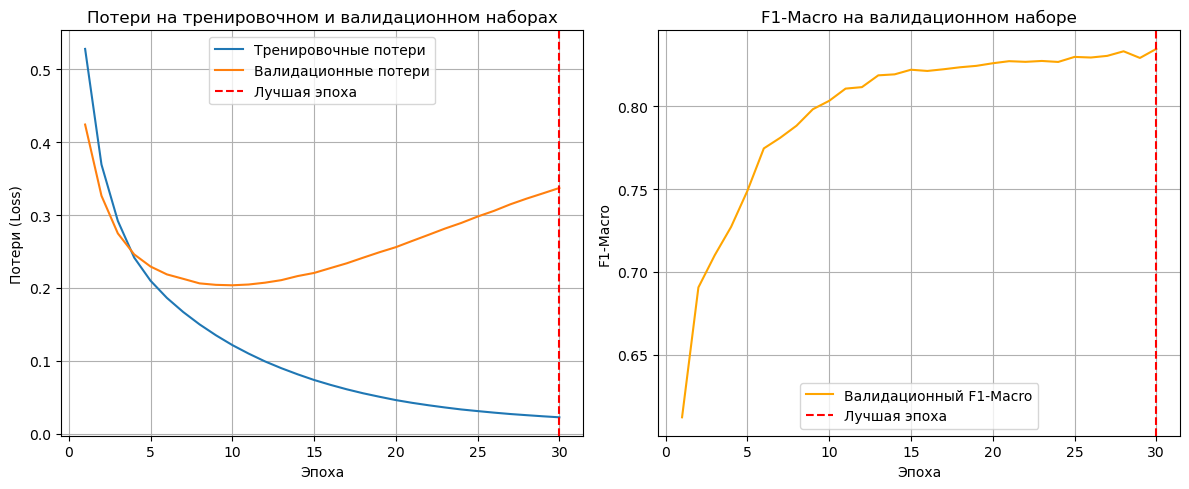

In [11]:
vectorizer_tfidf = TfidfVectorizer(
    max_features=20000, min_df=2, ngram_range=(1, 2), max_df=0.95
)

vectorizer_tfidf.fit(train_texts)


X_train_tfidf = vectorizer_tfidf.transform(train_texts)
X_val_tfidf = vectorizer_tfidf.transform(val_texts)


y_train = cleared_dataset_train["train"]["labels"]
y_val = cleared_dataset_train["test"]["labels"]

y_train_tensor = torch.tensor(y_train, dtype=torch.float)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

X_train_tensor_tfidf = torch.from_numpy(X_train_tfidf.todense()).float()
X_val_tensor_tfidf = torch.from_numpy(X_val_tfidf.todense()).float()

train_dataset_tfidf = TensorDataset(X_train_tensor_tfidf, y_train_tensor)
val_dataset_tfidf = TensorDataset(X_val_tensor_tfidf, y_val_tensor)

batch_size = 256

train_loader_tfidf = DataLoader(
    train_dataset_tfidf, batch_size=batch_size, shuffle=True
)
val_loader_tfidf = DataLoader(val_dataset_tfidf, batch_size=batch_size, shuffle=False)


class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_labels):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 5120)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(5120, 1024)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(1024, num_labels)

    def forward(self, x):
        hidden = self.fc1(x)
        hidden = self.relu(hidden)
        hidden = self.fc2(hidden)
        hidden = self.relu(hidden)
        logits = self.fc3(hidden)

        return logits


def train_epoch(model, train_dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataloader.dataset)
    return epoch_loss


def evaluate_model(model, val_dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).int()

            all_labels.append(labels.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())

    epoch_loss = running_loss / len(val_dataloader.dataset)

    all_labels = np.concatenate(all_labels, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    f1_macro = f1_score(all_labels, all_predictions, average="macro", zero_division=0)

    return epoch_loss, f1_macro


def _plot_metrics(epochs_list, train_losses, val_losses, val_f1_scores, epoch_best):
    plt.figure(figsize=(12, 5))

    actual_epochs = len(train_losses)
    epochs_plot = epochs_list[:actual_epochs]
    train_losses_plot = train_losses[:actual_epochs]
    val_losses_plot = val_losses[:actual_epochs]
    val_f1_scores_plot = val_f1_scores[:actual_epochs]

    plt.subplot(1, 2, 1)
    plt.plot(epochs_plot, train_losses_plot, label="Тренировочные потери")
    plt.plot(epochs_plot, val_losses_plot, label="Валидационные потери")
    plt.axvline(x=epoch_best, color="red", linestyle="--", label="Лучшая эпоха")
    plt.xlabel("Эпоха")
    plt.ylabel("Потери (Loss)")
    plt.title("Потери на тренировочном и валидационном наборах")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(
        epochs_plot, val_f1_scores_plot, label="Валидационный F1-Macro", color="orange"
    )
    plt.axvline(x=epoch_best, color="red", linestyle="--", label="Лучшая эпоха")
    plt.xlabel("Эпоха")
    plt.ylabel("F1-Macro")
    plt.title("F1-Macro на валидационном наборе")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def train(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    initial_optimizer,
    num_epochs,
    second_optimizer=None,
    metric_to_monitor="f1_macro",
    metric_patience=5,
    early_stopping_patience=None,
    initial_scheduler=None,
    device=device,
    best_model_save_path="models/model.pth",
):
    model.to(device)

    current_optimizer = initial_optimizer
    current_scheduler = initial_scheduler

    train_losses = []
    val_losses = []
    val_f1_scores = []
    epochs_list_full = list(range(1, num_epochs + 1))

    if metric_to_monitor == "f1_macro":
        best_metric = float("-inf")
        metric_comparison_op = np.greater
    elif metric_to_monitor == "val_loss":
        best_metric = float("inf")
        metric_comparison_op = np.less
    else:
        raise ValueError("metric_to_monitor must be 'f1_macro' or 'val_loss'")

    epochs_since_improvement = 0
    optimizer_switched = False
    epoch_best = -1

    for epoch in epochs_list_full:
        print(f"Эпоха {epoch}/{num_epochs}")
        print(
            f"Текущий оптимизатор: {type(current_optimizer).__name__}, LR: {current_optimizer.param_groups[0]['lr']:.6f}"
        )

        train_loss = train_epoch(
            model, train_dataloader, criterion, current_optimizer, device
        )
        train_losses.append(train_loss)
        print(f"Тренировочные потери (Loss): {train_loss:.4f}")

        val_loss, val_f1 = evaluate_model(model, val_dataloader, criterion, device)
        val_losses.append(val_loss)
        val_f1_scores.append(val_f1)
        print(f"Валидационные потери (Loss): {val_loss:.4f}, F1 Macro: {val_f1:.4f}")

        current_metric_value = val_f1 if metric_to_monitor == "f1_macro" else val_loss

        if metric_comparison_op(current_metric_value, best_metric):
            best_metric = current_metric_value
            epochs_since_improvement = 0
            if not os.path.exists(os.path.dirname(best_model_save_path)):
                os.makedirs(os.path.dirname(best_model_save_path), exist_ok=True)
            torch.save(model.state_dict(), best_model_save_path)
            epoch_best = epoch
            print(
                f"  Метрика ({metric_to_monitor}) улучшилась. Сохранена лучшая модель."
            )
        else:
            epochs_since_improvement += 1
            print(
                f"  Метрика ({metric_to_monitor}) не улучшилась. Эпох без улучшения: {epochs_since_improvement}"
            )

        if (
            not optimizer_switched
            and second_optimizer is not None
            and epochs_since_improvement >= metric_patience
        ):
            print(
                f"\n  Метрика '{metric_to_monitor}' не улучшалась в течение {metric_patience} эпох."
            )
            print("  Переключение оптимизатора...")

            current_optimizer = second_optimizer
            optimizer_switched = True
            epochs_since_improvement = 0
            current_scheduler = None

            print(
                f"  Теперь используется {type(current_optimizer).__name__} с LR={current_optimizer.param_groups[0]['lr']:.6f}"
            )

        if current_scheduler is not None:
            current_scheduler.step()
            print(
                f"  Шедулер сделал шаг. Текущий LR: {current_optimizer.param_groups[0]['lr']:.6f}"
            )

        if (
            early_stopping_patience is not None
            and epochs_since_improvement >= early_stopping_patience
        ):
            print(
                f"\nРанняя остановка! Метрика '{metric_to_monitor}' не улучшалась в течение {early_stopping_patience} эпох."
            )
            break

        print("-" * 20)

    if os.path.exists(best_model_save_path):
        model.load_state_dict(torch.load(best_model_save_path))
        print("Веса лучшей модели успешно загружены.")

    final_epoch_for_plot = epoch_best if epoch_best != -1 else len(train_losses)
    _plot_metrics(
        epochs_list_full, train_losses, val_losses, val_f1_scores, final_epoch_for_plot
    )

    return model


model_tfidf = MLPClassifier(
    input_dim=X_val_tfidf.shape[1],
    num_labels=y_train_tensor.shape[1],
).to(device)

criterion = nn.BCEWithLogitsLoss()
initial_optimizer = optim.AdamW(model_tfidf.parameters(), lr=1e-4)
second_optimizer = optim.AdamW(model_tfidf.parameters(), lr=1e-5)

training_results = train(
    model_tfidf,
    train_loader_tfidf,
    val_loader_tfidf,
    criterion,
    initial_optimizer=initial_optimizer,
    num_epochs=30,
    second_optimizer=second_optimizer,
    metric_to_monitor="f1_macro",
    metric_patience=3,
    initial_scheduler=None,
    early_stopping_patience=5,
    device=device,
    best_model_save_path="models/tf_idf.pth",
)


def generate_binary_predictions(model, test_texts, test_ids, device, vectorizer):
    model.eval()
    all_predictions_binary = []

    X = vectorizer.transform(test_texts)
    X_tensor = torch.from_numpy(X.todense()).float()
    X_dataset = TensorDataset(X_tensor)
    X_loader = DataLoader(X_dataset, batch_size=32, shuffle=False)

    with torch.no_grad():
        for batch_inputs in X_loader:
            inputs = batch_inputs[0].to(device)
            outputs = model(inputs)

            predictions_binary = (torch.sigmoid(outputs) > 0.5).int()

            all_predictions_binary.append(predictions_binary.cpu().numpy())

    all_predictions_binary = np.concatenate(all_predictions_binary, axis=0)
    label_strings = [" ".join(map(str, row)) for row in all_predictions_binary]

    submissions = pd.DataFrame({"id": test_ids, "labels": label_strings})

    return submissions


submissions = generate_binary_predictions(
    model_tfidf,
    test_texts=cleared_dataset_test["text"],
    test_ids=cleared_dataset_test["id"],
    device=device,
    vectorizer=vectorizer_tfidf,
)
submissions.to_csv("submission_tfidf.csv", index=False)